In [1]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

version_id = 'v3'

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [2]:
# get h5 datasets
repo_head = utils.get_repo_info()['head']
assert len(repo_head) > 0, "not running jupyter notebook from within a repo!! Prolly won't work :-)"
data_path = os.path.join(repo_head, "data/tightSVJ/10h5/*_data.h5")

# replace above code for 'data_path' if you want something else
data, jet_tables = utils.get_training_data_jets(data_path)

data.cdrop(["jetM", "*MET*", "*Delta*"], inplace=True)

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_5_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_4_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_3_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_2_data.h5'
data_loader

,jetEta,jetPhi,jetPt,jetChargedFraction,jetPTD,jetAxis2,jetFlavor,jetEnergy
0,0.292314,-1.215342,811.505066,0.617647,0.292997,0.015287,1.0,847.437136
1,-1.108254,0.154565,792.122620,0.600000,0.234078,0.025373,3.0,1331.724071
2,0.131421,-2.197223,665.996277,0.526316,0.198135,0.021002,3.0,674.659860
3,-1.134106,1.502835,942.049133,0.619048,0.277420,0.018531,2.0,1616.606413
4,-0.058697,2.968807,753.037720,0.500000,0.407907,0.027717,2.0,756.594176
5,-0.116076,-1.582877,1224.752563,0.575758,0.193657,0.020776,4.0,1240.268663
6,-0.522428,-1.064521,1240.000854,0.672414,0.214055,0.022217,1.0,1415.601506
7,0.479513,2.142449,1163.479126,0.550000,0.283502,0.020701,3.0,1313.717833
8,0.785336,1.244235,713.023560,0.421053,0.222477,0.100818,2.0,946.259955
9,-0.561334,-1.531905,962.493652,0.378378,0.392954,0.022140,1.0,1119.513002


In [3]:
tagged, tag_index = utils.split_table_by_column(
    "jetFlavor",
    data,
    utils.delphes_jet_tags_dict,
    False
)
sizes = map(lambda x: x.shape[0], tagged)
for t,s in zip(tagged, sizes):
    print  "{} jet: {}, {}%".format(t.name, s, round(100.*s/sum(sizes), 1))

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

down:
	18.4% (14250) train
	18.4% (4749) test
	18.4% (18999) original
up:
	37.7% (29220) train
	37.2% (9621) test
	37.6% (38841) original
strange:
	24.4% (18924) train
	25.0% (6453) test
	24.5% (25377) original
charm:
	9.3% (7196) train
	9.2% (2381) test
	9.3% (9577) original
bottom:
	3.2% (2500) train
	3.3% (841) test
	3.2% (3341) original
gluon:
	7.1% (5472) train
	7.0% (1809) test
	7.0% (7281) original
data_table :: plotting distrubution(s) for table(s) ['train_down', 'test_down', 'down']


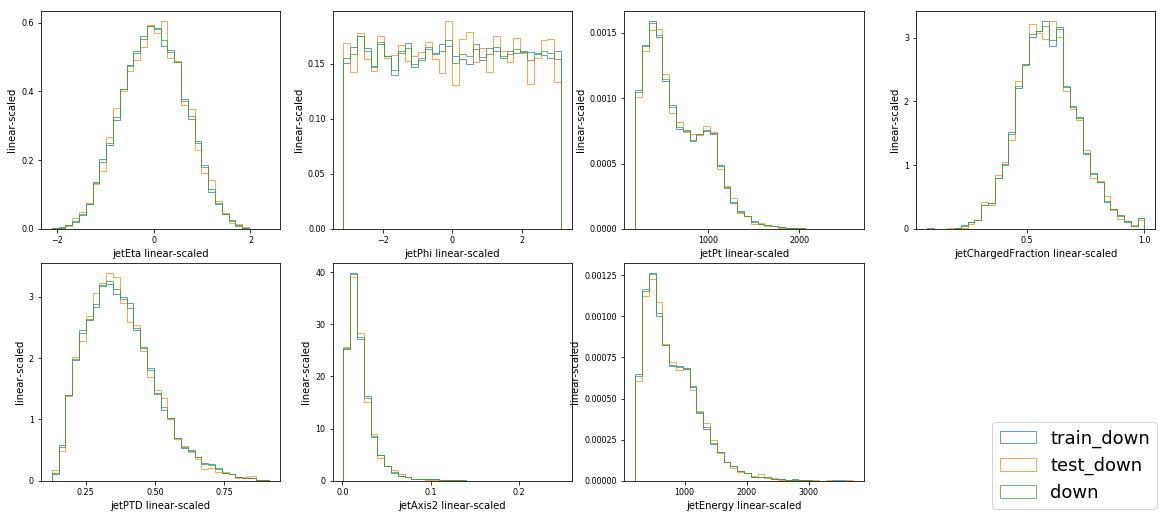

data_table :: plotting distrubution(s) for table(s) ['train_up', 'test_up', 'up']


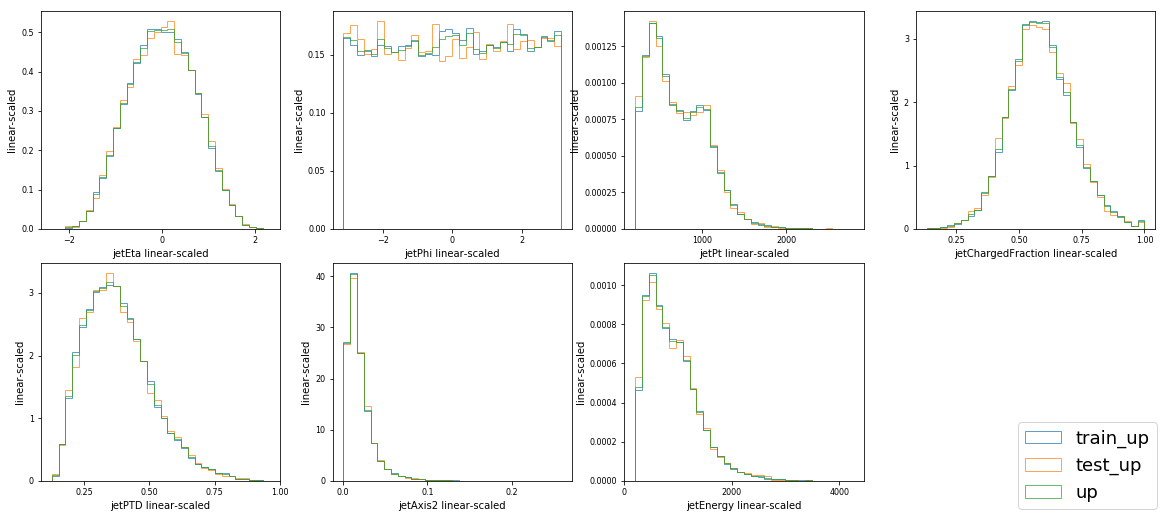

data_table :: plotting distrubution(s) for table(s) ['train_strange', 'test_strange', 'strange']


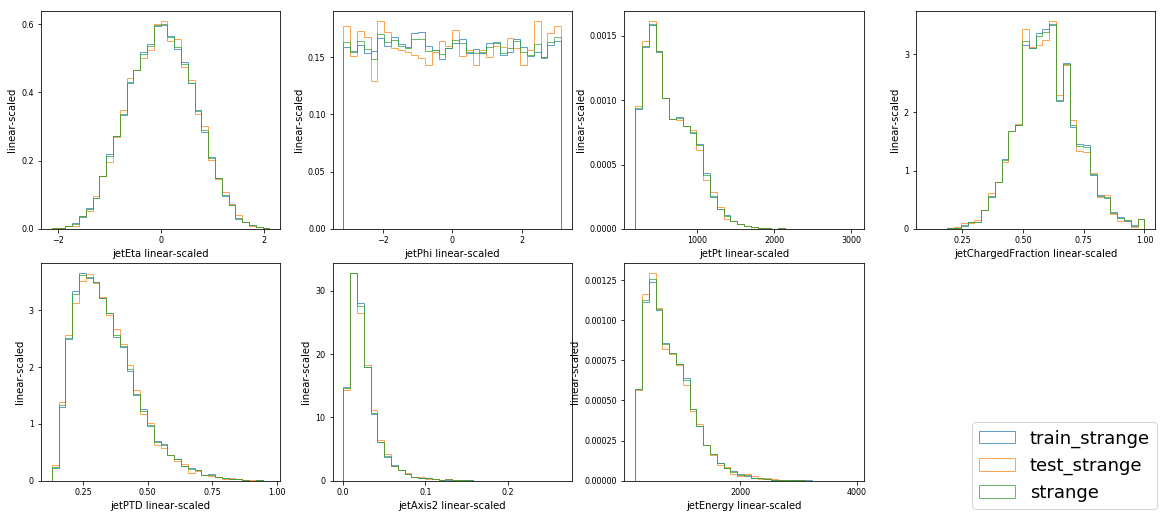

data_table :: plotting distrubution(s) for table(s) ['train_charm', 'test_charm', 'charm']


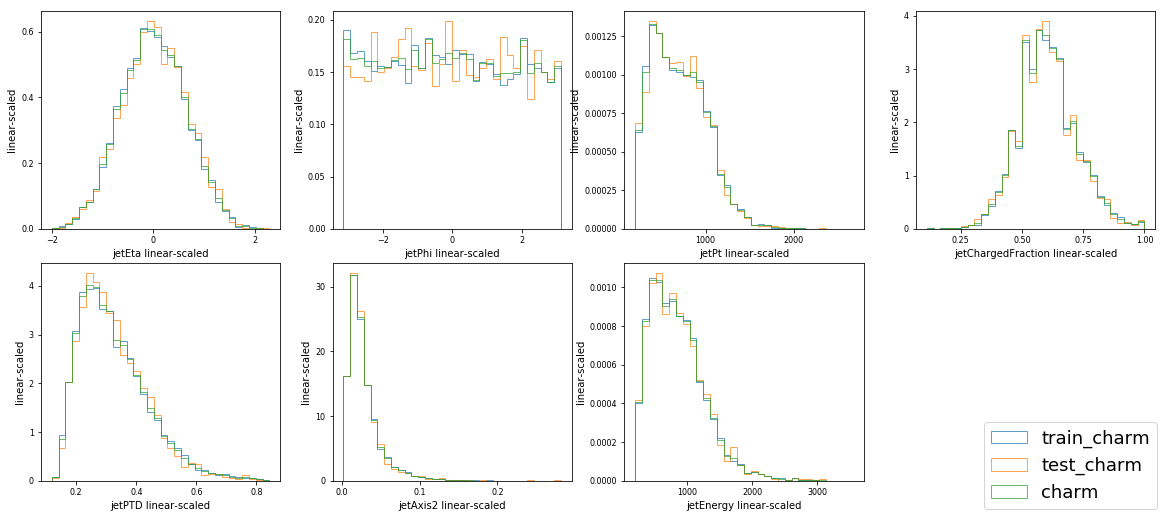

data_table :: plotting distrubution(s) for table(s) ['train_bottom', 'test_bottom', 'bottom']


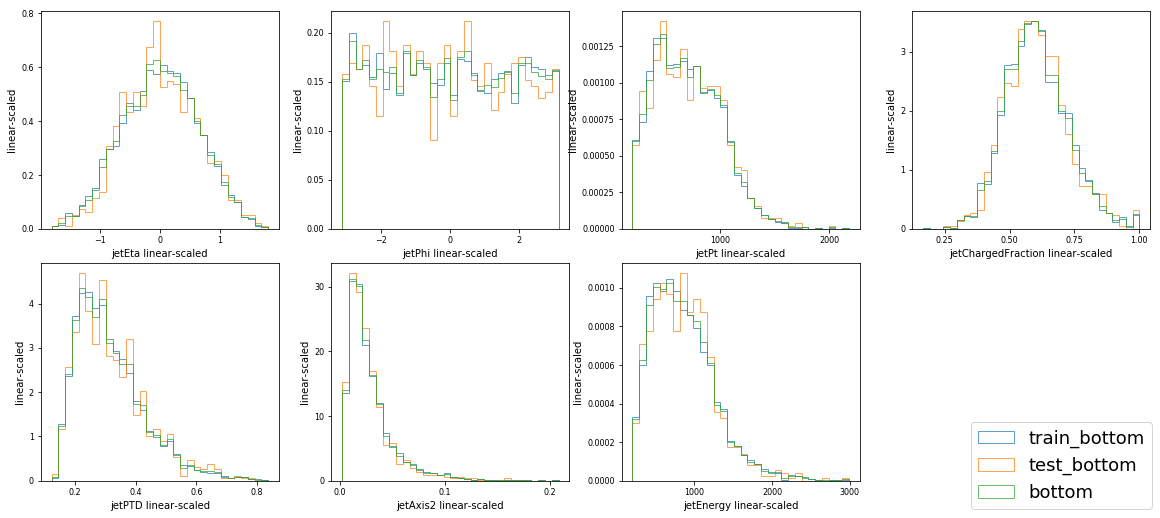

data_table :: plotting distrubution(s) for table(s) ['train_gluon', 'test_gluon', 'gluon']


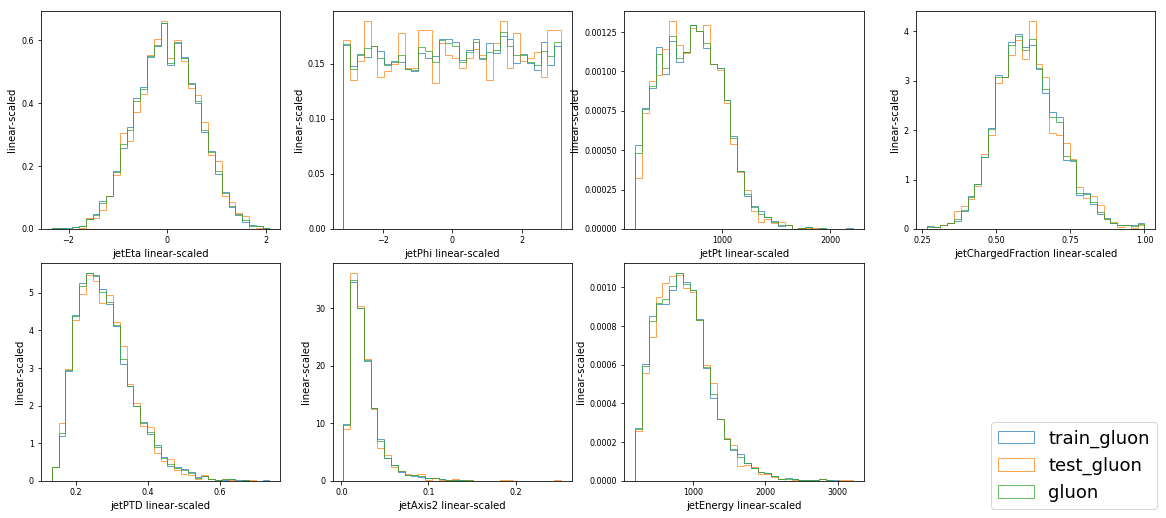

In [4]:
split = 0.25

train, test = data.train_test_split(split)

train_tags, test_tags = map(
    lambda x: utils.split_table_by_column(
        "jetFlavor", x,
        utils.delphes_jet_tags_dict, False
    )[0],
    [train, test]
)

for trt, tet in zip(train_tags, test_tags):
    print "{}:".format(trt.name)
    print "\t{:.1f}% ({}) train".format(100.*trt.shape[0]/train.shape[0], trt.shape[0])
    print "\t{:.1f}% ({}) test".format(100.*tet.shape[0]/test.shape[0], tet.shape[0])
    print "\t{:.1f}% ({}) original".format(100.*(tet.shape[0] + trt.shape[0])/data.shape[0], trt.shape[0] + tet.shape[0])

for full, trt, tet in zip(tagged, train_tags, test_tags):
    trt.name = "train_" + trt.name
    tet.name = "test_" + tet.name
    trt.plot([tet, full], normed=1)

# data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
# data.plot(jet_tables, normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)

data_table :: plotting distrubution(s) for table(s) ['down', 'up', 'strange', 'charm', 'bottom', 'gluon']


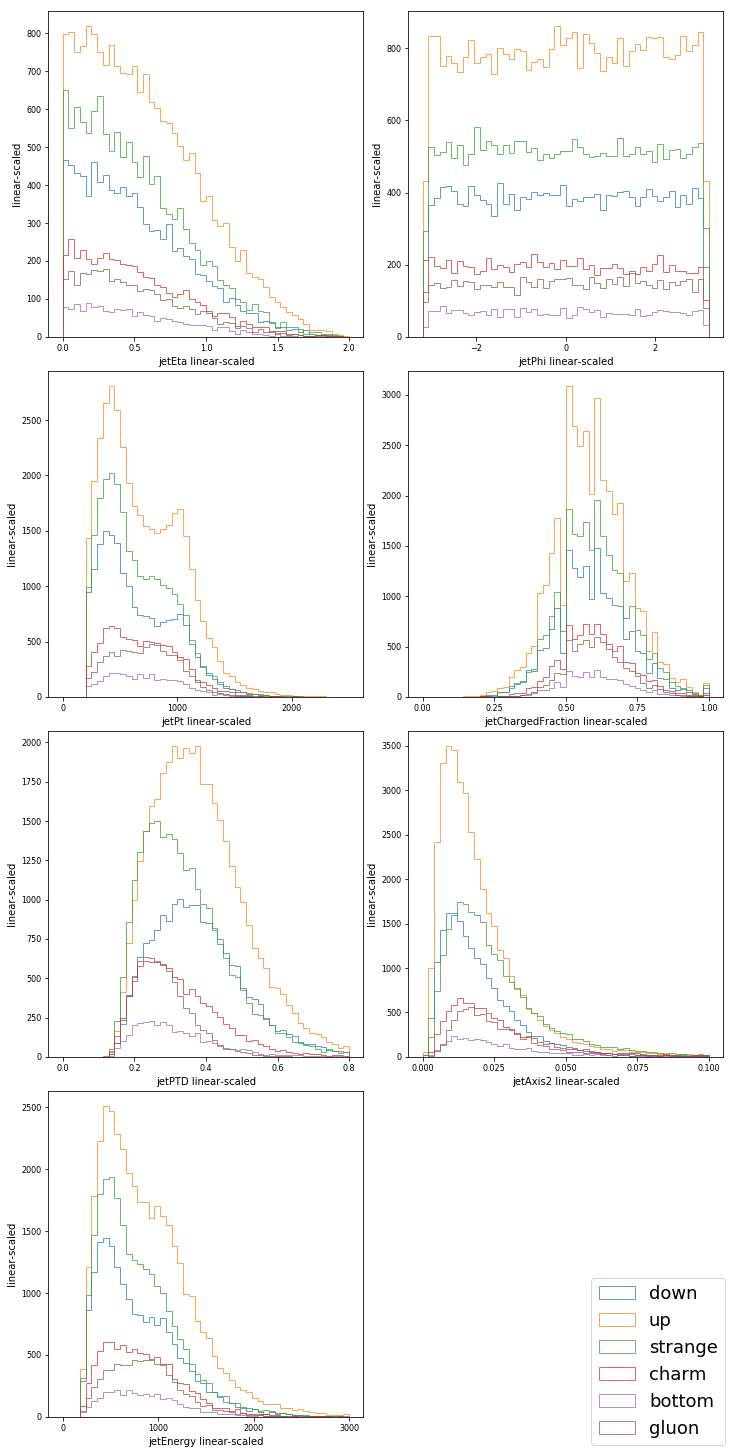

In [95]:
tagged[0].plot(tagged[1:], normed=0, bins=50, cols=2, figsize=(10,20), rng=(
        (0,2), (-3.2, 3.2), (0,2500), (0,1), (0, 0.8),(0,.1), (0,3000)))

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetChargedFraction', 'jetPTD', 'jetAxis2', 'jetEnergy']


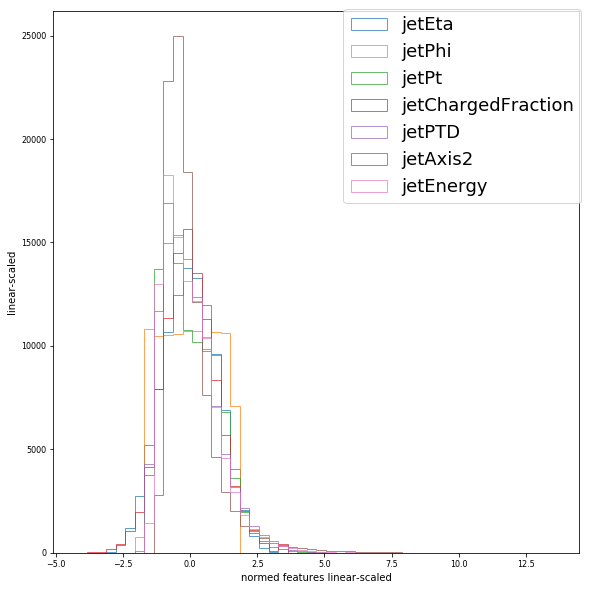

In [46]:
raw = data.cdrop("*Flavor")

norm_args = {
    "norm_type": "StandardScaler",
#     "feature_range": (0.01, 0.99)
}

train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")
train_norm, test_norm = train_raw.norm(**norm_args), train_raw.norm(test_raw, **norm_args)

norm = train_raw.norm(raw, **norm_args)
features = [utils.data_table(norm[c].values.reshape(norm[c].shape[0],1), name=c, headers=["normed features"]) for c in norm]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10, figloc="upper right")

# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

we will use `RobustScaler`, because the results look the best (and train the best ;-))

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [47]:
bn = 5
name = "bn_{1}_{0}".format(version_id, bn)
path = "autoencode/data/training_runs/7jf/custom"

ae_skeleton = models.base_autoencoder()
ae_skeleton.add(7)
ae_skeleton.add(20)
ae_skeleton.add(bn, 'relu')
ae_skeleton.add(20)
ae_skeleton.add(7, "linear")
autoencoder = ae_skeleton.build()
encoder, decoder = autoencoder.layers[1:]
instance = trainer.trainer(os.path.join(os.path.join(repo_head, path), name))

h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'bn_5_v3.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'bn_5_v3.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'bn_5_v3.h5'


... and the model summaries:

In [48]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 20)                160       
_________________________________________________________________
layer_3 (Dense)              (None, 5)                 105       
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
layer_4 (Dense)              (None, 20)                120       
__________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [49]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [87]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred), axis=-1)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=-1)
    return SS_res/SS_tot

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss='mse',
    epochs=5,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=254,
    use_callbacks=True,
    learning_rate=0.005
)

train_shell :: using model passed as function argument
Train on 77562 samples, validate on 25854 samples
Epoch 21/25
305/305 [==============================] - 12s 40ms/step - loss: 0.0106 - r_square: 0.9894 - mean_absolute_error: 0.0527 - mean_squared_error: 0.0106 - val_loss: 0.0101 - val_r_square: 0.9899 - val_mean_absolute_error: 0.0492 - val_mean_squared_error: 0.0101
Epoch 22/25
305/305 [==============================] - 11s 34ms/step - loss: 0.0100 - r_square: 0.9900 - mean_absolute_error: 0.0492 - mean_squared_error: 0.0100 - val_loss: 0.0101 - val_r_square: 0.9899 - val_mean_absolute_error: 0.0491 - val_mean_squared_error: 0.0101
Epoch 23/25
305/305 [==============================] - 10s 34ms/step - loss: 0.0100 - r_square: 0.9900 - mean_absolute_error: 0.0498 - mean_squared_error: 0.0100 - val_loss: 0.0101 - val_r_square: 0.9899 - val_mean_absolute_error: 0.0492 - val_mean_squared_error: 0.0101
Epoch 24/25
305/305 [==============================] - 11s 35ms/step - loss: 0.010

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

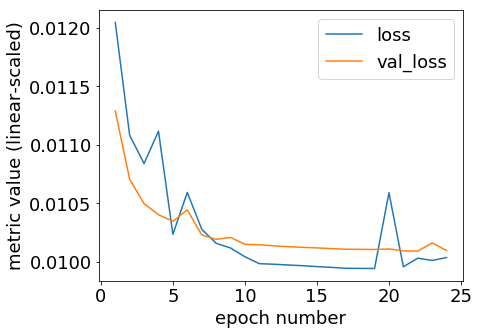

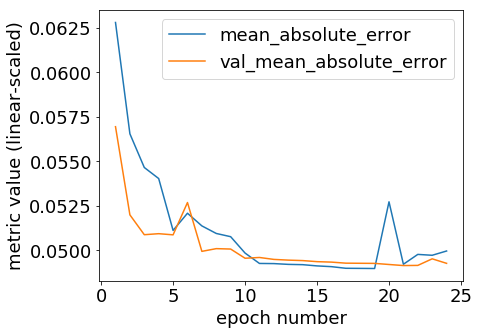

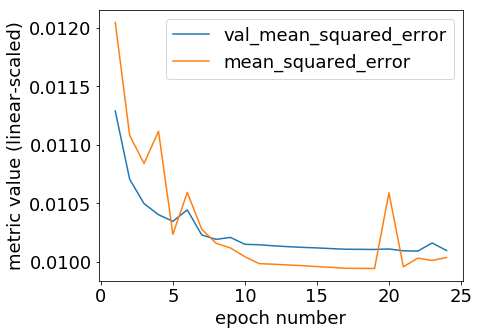

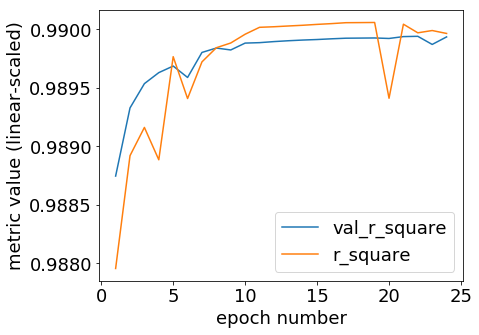

In [88]:
instance.plot_metrics(fnmatch_criteria="*loss*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*squared*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


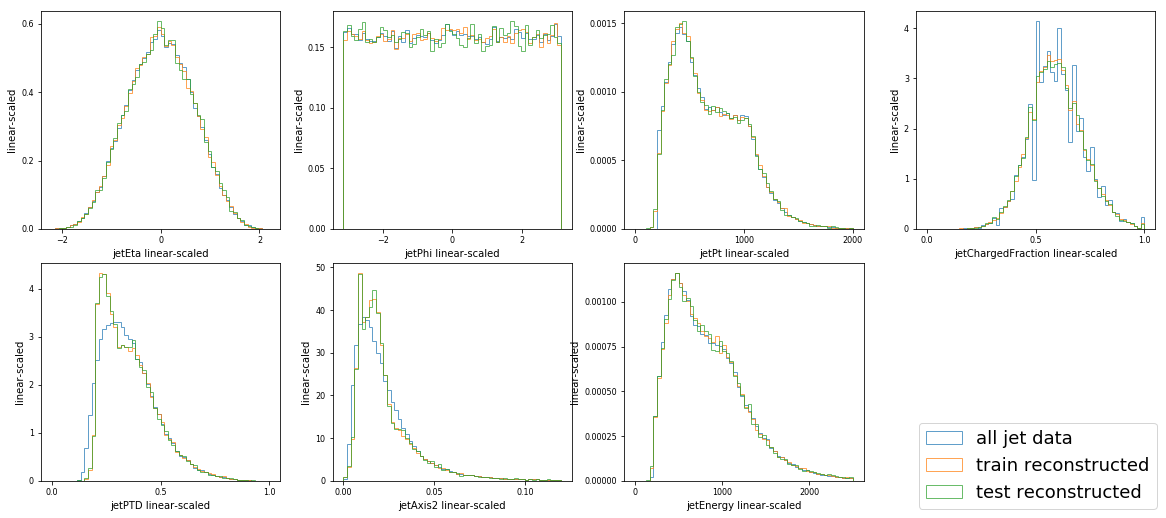

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


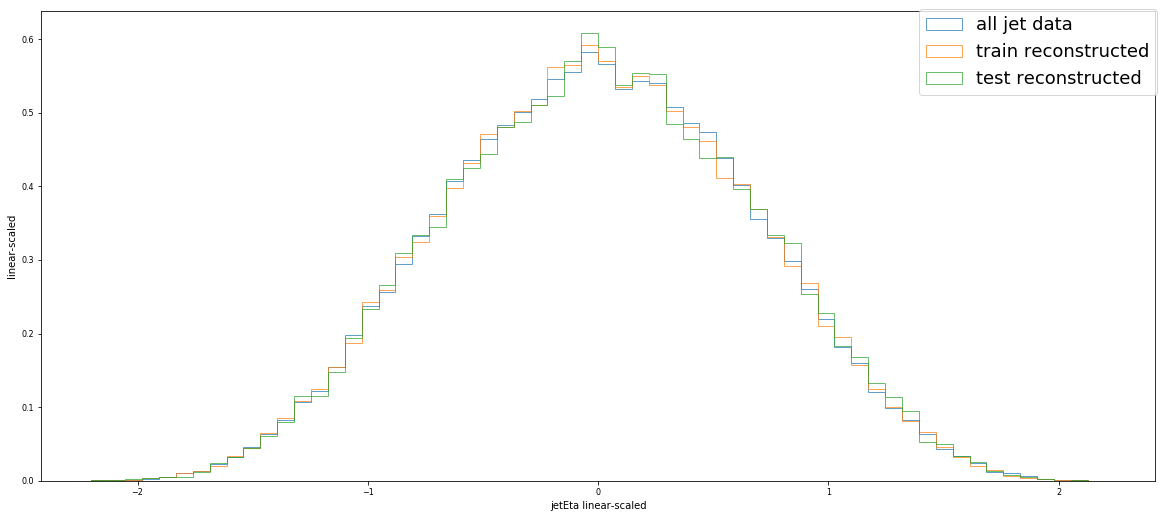

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


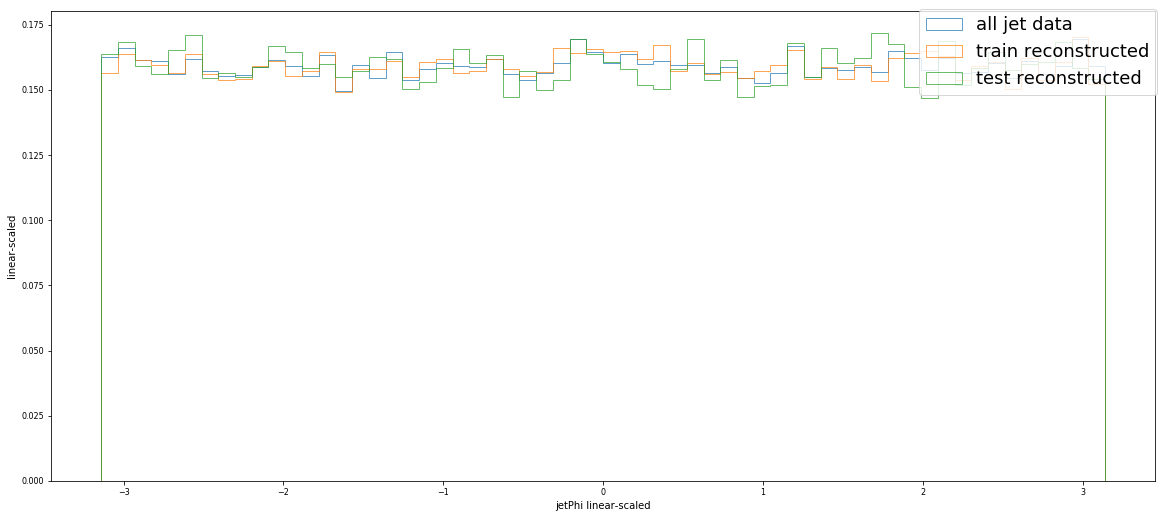

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


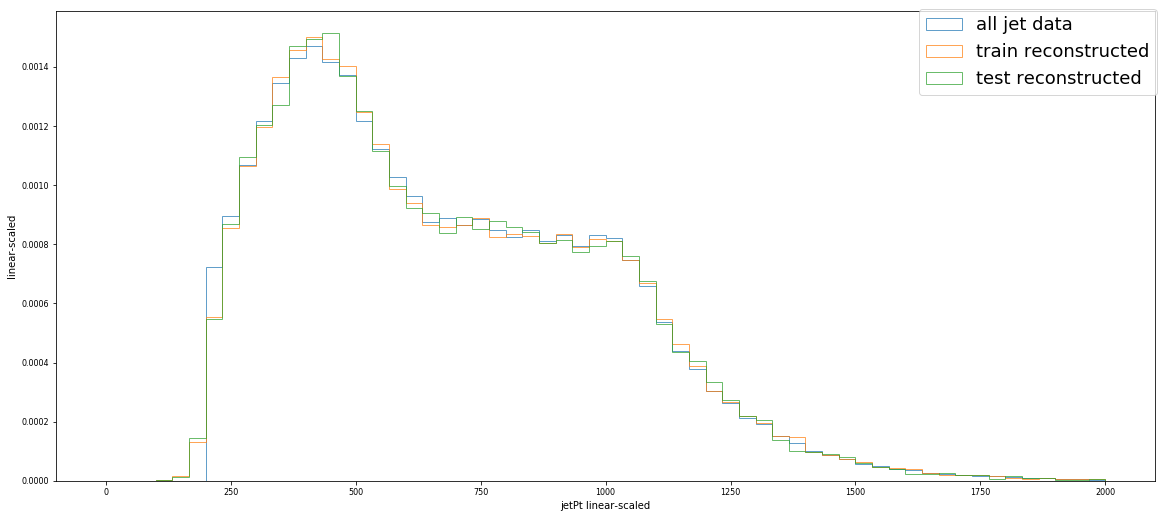

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


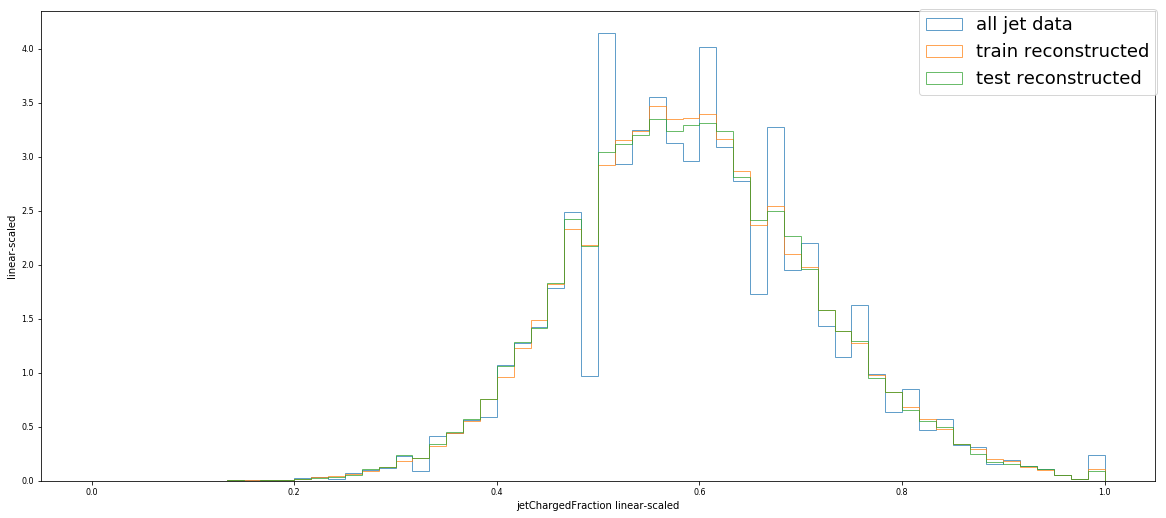

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


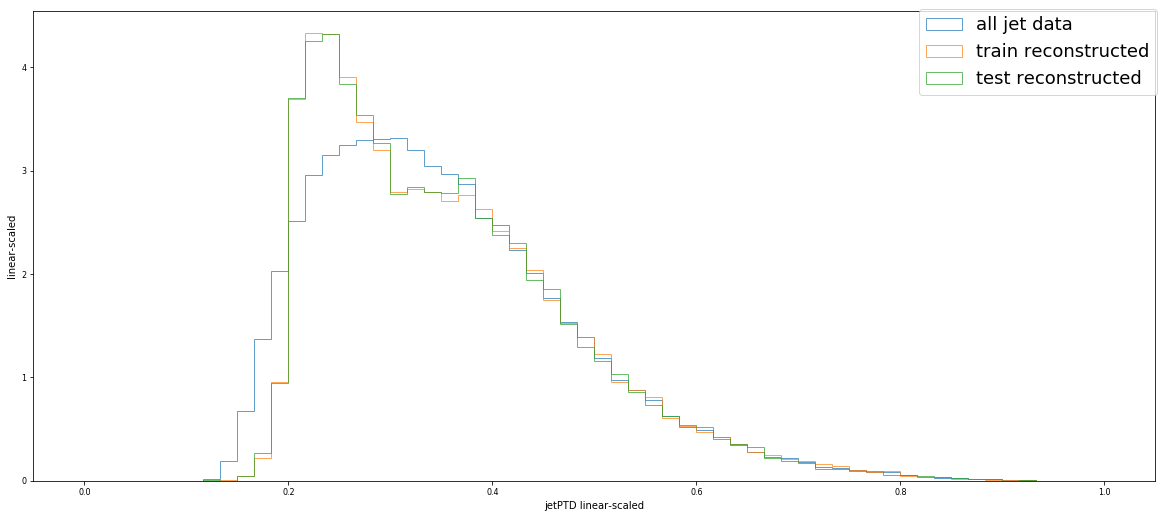

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


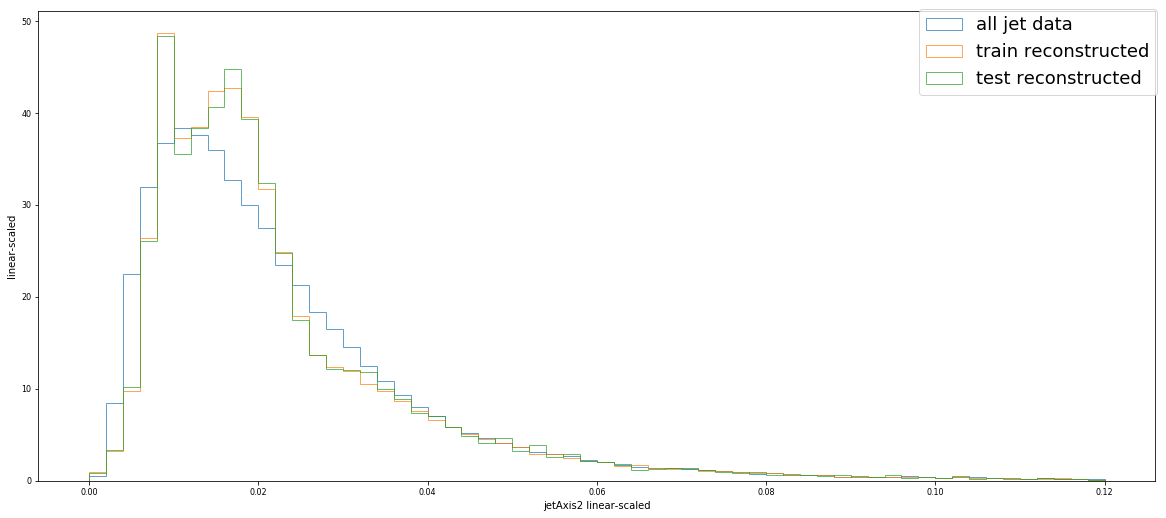

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train reconstructed', 'test reconstructed']


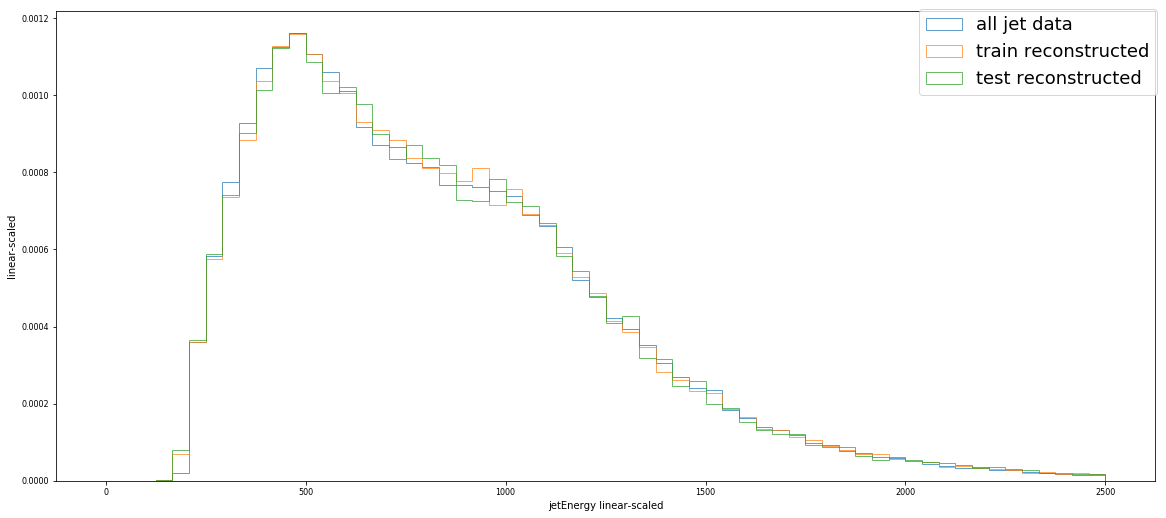

In [92]:

# data_recon_norm = utils.data_table(autoencoder.predict(.norm(**norm_args).df.values), headers=train_norm.headers)
# data_recon = data.inorm(data_recon_norm, **norm_args)
# data_recon.name = "all jet data (pred)"

train_reconstructed_norm = utils.data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
test_reconstructed_norm = utils.data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)
data_reconstructed_norm = utils.data_table(autoencoder.predict(norm.data), headers=norm.headers)

train_reconstructed = train_raw.inorm(train_reconstructed_norm, **norm_args)
test_reconstructed = train_raw.inorm(test_reconstructed_norm, **norm_args)
data_reconstructed = train_raw.inorm(data_reconstructed_norm, **norm_args)

train_reconstructed.name = "train reconstructed"
test_reconstructed.name = "test reconstructed"
data_reconstructed.name = "data reconstructed"

# train_reconstructed_norm.plot([train_norm], values='jetAxis2', bins=70, rng=(0,0.5))
rngs = [
    (-2.2,2.2),
    (-3.14,3.14),
    (0,2000.),
    (0,1.),
    (0,1.),
    (0,.12),
    (0,2500),
]

raw.plot([train_reconstructed, test_reconstructed], normed=1, bins=60, rng=rngs)
for c,rng in zip(raw.headers, rngs):
    raw.plot([train_reconstructed, test_reconstructed], normed=1, values=c, rng=rng, bins=60, figloc='upper right')

The bottleneck node values:

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


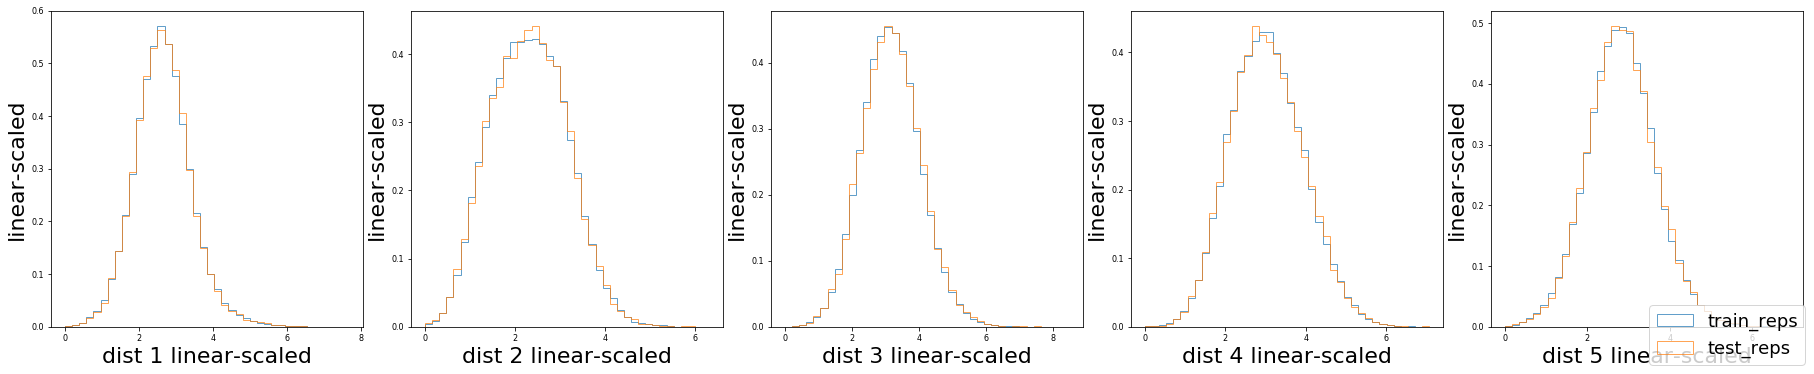

In [93]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)
train_reps.plot([test_reps], cols=5, figsize=(25,5), fontsize=22, normed=1, bins=40)

In [223]:
def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def get_errors(true, pred, out_name="errors", functions=["mse", "mae", r_square_np], names=[None, None, "r_square"]):
    import tensorflow as tf
    if names is None:
        names = ['err {}'.format(i) for i in range(len(functions))]
    
    functions_keep = []
    for i,f in enumerate(functions):
        if isinstance(f, str):
            fuse = getattr(keras.losses, f)
            functions_keep.append(fuse)
            names[i] = f
        else:
            functions_keep.append(f)
    
    raw = [func(true, pred) for func in functions_keep]
    raw = np.asarray(map(lambda x: K.eval(x) if isinstance(x, tf.Tensor) else x, raw)).T
    return utils.data_table(
        raw,
        headers=[str(f) for f in names],
        name=out_name
    )

errors = get_errors(norm.data, data_reconstructed_norm.data, "all errors")
tagged_norm = [train_raw.norm(t, **norm_args) for t in tagged]
# tagged_recon_norm = [utils.data_table(autoencoder.predict(t.data), name=t.name + "_norm", headers=t.headers) for t in tagged]
errors_tagged = [get_errors(t.data, autoencoder.predict(t.data), "error " + t.name.split("normed")[0].strip().strip("'")) for t in tagged_norm]

data_table :: plotting distrubution(s) for table(s) ['all errors', 'error down', 'error up', 'error strange', 'error charm', 'error bottom', 'error gluon']


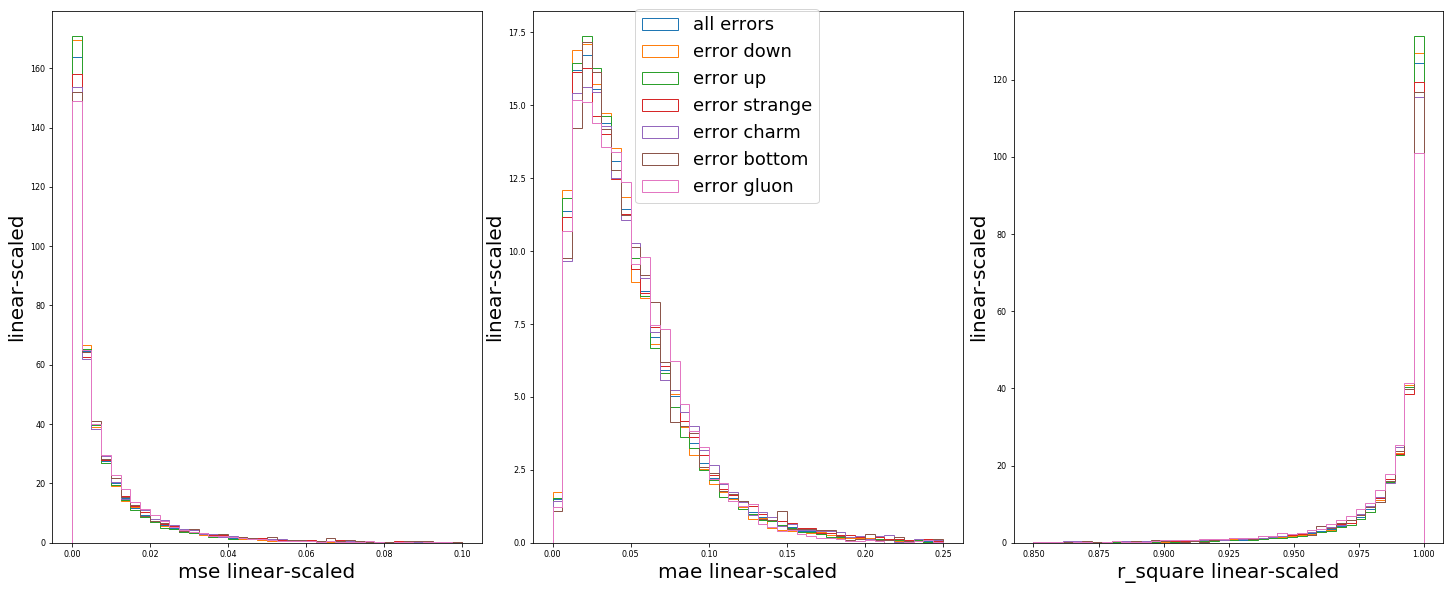

data_table :: plotting distrubution(s) for table(s) ['all errors', 'error down', 'error up', 'error strange', 'error charm', 'error bottom', 'error gluon']


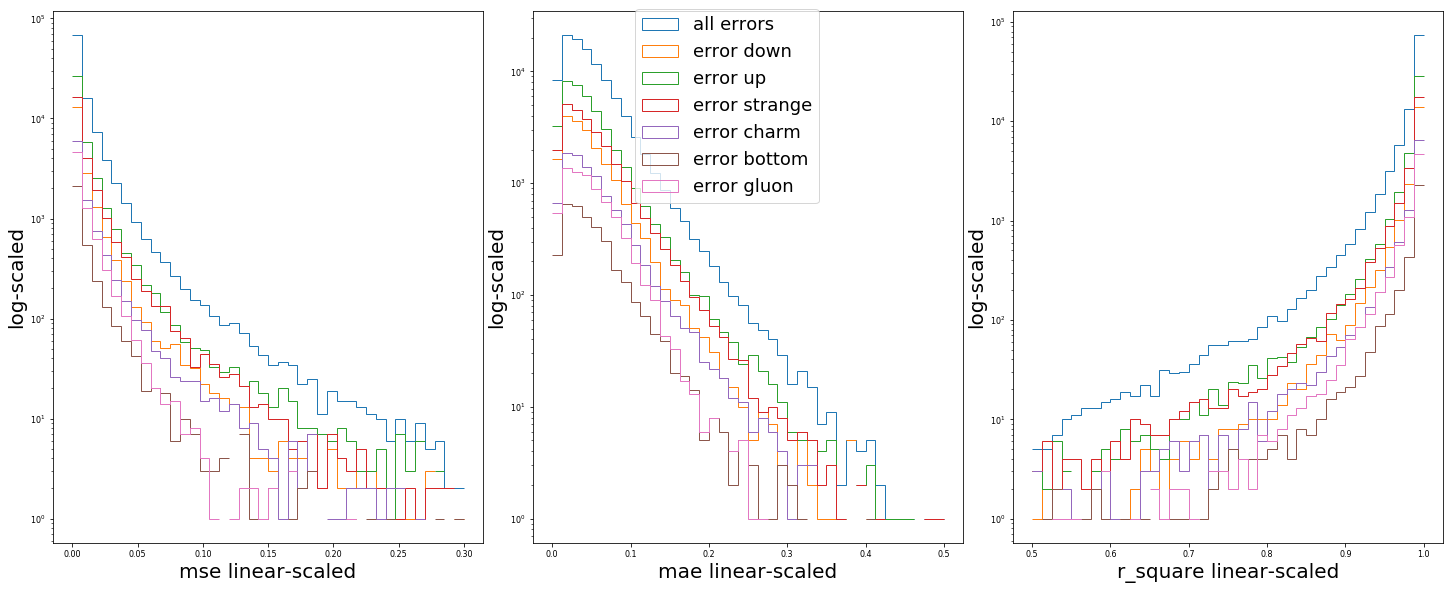

In [268]:
errors.plot(
    errors_tagged,
    figsize=(20,8), 
    bins=40,
    rng=((0,0.1), (0, 0.25), (.85,1)),
    fontsize=20, cols=3, 
    figloc="upper center",
    normed=True,
    yscale="linear",
    histtype="step",
    alpha=1
)
errors.plot(
    errors_tagged,
    figsize=(20,8), 
    bins=40,
    rng=((0,0.3), (0, 0.5), (.5,1)),
    fontsize=20, cols=3, 
    figloc="upper center",
    normed=False,
    yscale="log",
    histtype="step",
    alpha=1
)